<a href="https://colab.research.google.com/github/shrutin567/Stock-Market-Prediction/blob/main/market_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Stock Market Prediction**

*(train a random forest model and make predictions using backtesting)*

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Import the necessary packages and Displaying the data


In [6]:
import yfinance as yf #pkg calls the yahoo finance api to download daily stock and index prices

In [3]:
sp500=yf.Ticker("^GSPC") #ticker class- will enable us to download price history for a single symbol

In [4]:
sp500=sp500.history(period="max") #query the historical prices- query all data from the beginning when the index was created

In [5]:
sp500 #a Pandas DataFrame - each row is the price on a single trading day (non trading days are not included in this data)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-08-21 00:00:00-04:00,4380.279785,4407.549805,4360.299805,4399.770020,3726850000,0.0,0.0
2023-08-22 00:00:00-04:00,4415.330078,4418.589844,4382.770020,4387.549805,3522760000,0.0,0.0
2023-08-23 00:00:00-04:00,4396.439941,4443.180176,4396.439941,4436.009766,3837270000,0.0,0.0


^
columns:

-**Open**: opening price; price when the market opened

-**High**: highest price during the day

-**Low**: lowest price during the day

-**Close**: closing price when the exchange closed

-**Volume**: the volume that was traded that day

we will use the above columns to ***predict if the stock price will go up or down tomorrow***.

we have additional columns (Dividends, Stock Splits), which we will remove later.

In [7]:
sp500.index #will enable us to index and slice the data frame easily

DatetimeIndex(['1927-12-30 00:00:00-05:00', '1928-01-03 00:00:00-05:00',
               '1928-01-04 00:00:00-05:00', '1928-01-05 00:00:00-05:00',
               '1928-01-06 00:00:00-05:00', '1928-01-09 00:00:00-05:00',
               '1928-01-10 00:00:00-05:00', '1928-01-11 00:00:00-05:00',
               '1928-01-12 00:00:00-05:00', '1928-01-13 00:00:00-05:00',
               ...
               '2023-08-14 00:00:00-04:00', '2023-08-15 00:00:00-04:00',
               '2023-08-16 00:00:00-04:00', '2023-08-17 00:00:00-04:00',
               '2023-08-18 00:00:00-04:00', '2023-08-21 00:00:00-04:00',
               '2023-08-22 00:00:00-04:00', '2023-08-23 00:00:00-04:00',
               '2023-08-24 00:00:00-04:00', '2023-08-25 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=24028, freq=None)

# Cleaning and Visualizing our Stock Market Data

<Axes: xlabel='Date'>

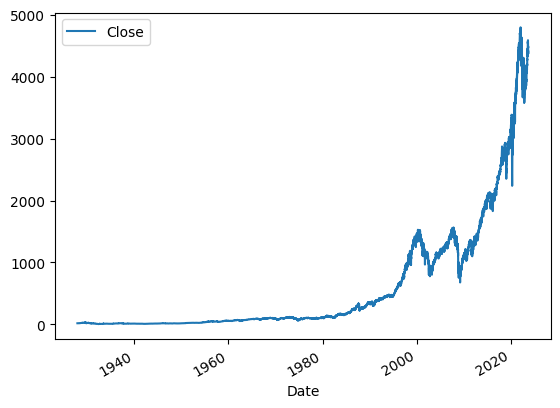

In [8]:
sp500.plot.line(y="Close",use_index=True) #x-axis: date, y-axis: closing price

^chart of the S&P 500 price history

the stocks were really good in the past few years!

*data cleaning*

In [9]:
del sp500["Dividends"]
del sp500["Stock Splits"] #these columns are more appropriate for individual stocks, not an index

# Setting up our target for machine learning

**target: will the price go up or down tomorrow?**

Our machine learning model's focus is on predicting the direction of stock price movement rather than the absolute price

In [10]:
sp500["Tomorrow"]=sp500["Close"].shift(-1)

In [11]:
sp500

,Open,High,Low,Close,Volume,Tomorrow
Date,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.760000
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,17.719999
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,17.549999
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,17.660000
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.500000
...,...,...,...,...,...,...
2023-08-21 00:00:00-04:00,4380.279785,4407.549805,4360.299805,4399.770020,3726850000,4387.549805
2023-08-22 00:00:00-04:00,4415.330078,4418.589844,4382.770020,4387.549805,3522760000,4436.009766
2023-08-23 00:00:00-04:00,4396.439941,4443.180176,4396.439941,4436.009766,3837270000,4376.310059


^ e.g., for 2023-08-21, the Tomorrow column is the Close column (closing price) for 2023-08-22.

In [12]:
sp500["Target"]=(sp500["Tomorrow"]>sp500["Close"]).astype(int)
#we need to check if tomorrow's price is greater than today's price
#returns a boolean value, convert it to an integer so as to use it in ML


In [13]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.760000,1
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,17.719999,0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,17.549999,0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,17.660000,1
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.500000,0
...,...,...,...,...,...,...,...
2023-08-21 00:00:00-04:00,4380.279785,4407.549805,4360.299805,4399.770020,3726850000,4387.549805,0
2023-08-22 00:00:00-04:00,4415.330078,4418.589844,4382.770020,4387.549805,3522760000,4436.009766,1
2023-08-23 00:00:00-04:00,4396.439941,4443.180176,4396.439941,4436.009766,3837270000,4376.310059,0


with stock market data if we go back too far, some of the data might not be useful in making future predictions due to fundamental market shifts

In [15]:
#remove all data that came before 1990
sp500=sp500.loc["1990-01-01":].copy()

In [16]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0
...,...,...,...,...,...,...,...
2023-08-21 00:00:00-04:00,4380.279785,4407.549805,4360.299805,4399.770020,3726850000,4387.549805,0
2023-08-22 00:00:00-04:00,4415.330078,4418.589844,4382.770020,4387.549805,3522760000,4436.009766,1
2023-08-23 00:00:00-04:00,4396.439941,4443.180176,4396.439941,4436.009766,3837270000,4376.310059,0


# Training an initial Machine Learning model

***random forest classifier*** (harder for them to overfit, run relative quickly, pick up non-linear tendencies in the data)

e.g.
the open price is not linearly correlated with the target.

there's no linear relationship between the open price and the target. if the open price is higher, it doesn't mean that the target will also be higher. our rf can pick up non-linear relationships.


In [19]:
from sklearn.ensemble import RandomForestClassifier

#to prevent overfitting
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

#to prevent leakage into the model
#training and test sets
#simple baseline model
train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
#fit the model
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [21]:
#accuracy of the model
#what % of the time when we said that the market will go up, did it actually go up
#assumption: we want to buy stock and we want to hold that stock and sell and we want to make sure that the stock price is actually going to increase

from sklearn.metrics import precision_score

preds = model.predict(test[predictors])

In [22]:
preds #numpy array

array([1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

In [25]:
import pandas as pd

preds=pd.Series(preds,index=test.index)

In [26]:
preds

Date
2023-04-04 00:00:00-04:00    1
2023-04-05 00:00:00-04:00    0
2023-04-06 00:00:00-04:00    0
2023-04-10 00:00:00-04:00    0
2023-04-11 00:00:00-04:00    0
                            ..
2023-08-21 00:00:00-04:00    1
2023-08-22 00:00:00-04:00    1
2023-08-23 00:00:00-04:00    1
2023-08-24 00:00:00-04:00    1
2023-08-25 00:00:00-04:00    0
Length: 100, dtype: int64

In [27]:
precision_score(test["Target"],preds)

0.5362318840579711

^ not a great precision score; when we said that the prices would go up, that only went up 53% percent of the time!

In [30]:
#plot our predictions
combined=pd.concat([test["Target"],preds],axis=1)

<Axes: xlabel='Date'>

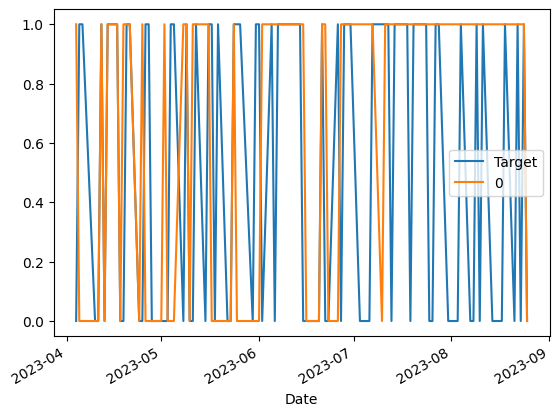

In [31]:
combined.plot()

^ *orange line (0) : our predictions*

*blue line: what actually happened*

we mostly predicted that the market would go up, but mostly it seems to have gone down :]

that explains why our predictions were so far off...

# Building a Backtesting System

build a more robust  way to test our algorithm

currently, we are only able to test our model against the last 100 days. but if we're really building a stock price model and we want to use it in the real world, we want to be able to *test it across multiple years of data* because we want to know how our algorithm is going to handle a lot of different situations. this gives us more confidence that it'll work in the future.

In [32]:
def predict(train,test,predictors,model):
  model.fit(train[predictors],train["Target"])
  preds=model.predict(test[predictors])
  preds=pd.Series(preds,index=test.index,name="Predictions")
  combined=pd.concat([test["Target"],preds],axis=1)
  return combined

In [33]:
def backtest(data,model,predictors,start=2500,step=250):
  all_predictions=[]

  for i in range(start,data.shape[0],step):
    train=data.iloc[0:i].copy()
    test=data.iloc[i:(i+step)].copy()
    predictions=predict(train,test,predictors,model)
    all_predictions.append(predictions)
  return pd.concat(all_predictions)

In [34]:
predictions=backtest(sp500,model,predictors)

In [35]:
#evaluating the errors of our predictions

predictions["Predictions"].value_counts()

0    3434
1    2544
Name: Predictions, dtype: int64

In [37]:
precision_score(predictions["Target"],predictions["Predictions"])

0.5290880503144654

In [38]:
predictions["Target"].value_counts()/predictions.shape[0]

1    0.533623
0    0.466377
Name: Target, dtype: float64

# Adding additional predictors to our model

In [40]:
#create a variety of rolling averages
#if you're a human analyst trying to predict if the stock will go up tomorrow,
#some of the nos. you might look at are , is the stock price today higher than it was last week/3 months ago/1 year ago/5 years ago
#you might use all of those inputs to help you determine if the stock will go up or down
#we're going to give the algorithm that information
#we'll calculate the mean close price in the last 2 days, the last trading week (5 days), 60 trading days (3 months), 250 trading days (1 year), 4 trading years (1000 days)
#we'll find the ratio between today's closing price and the closing price in those periods
#this will help us know if the market has gone up a ton, because of so it may be due to a downturn (vice versa, upswing)


horizons=[2,5,60,250,1000]

new_predictors=[]

for horizon in horizons:
  rolling_averages=sp500.rolling(horizon).mean()

  ratio_column=f"Close_Ratio_{horizon}"
  sp500[ratio_column]=sp500["Close"]/rolling_averages["Close"]

  trend_column=f"Trend_{horizon}"
  sp500[trend_column]=sp500.shift(1).rolling(horizon).sum()["Target"]

  new_predictors+=[ratio_column,trend_column]

In [41]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0,0.998706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0,0.995675,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1,0.995098,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0,1.002252,1.0,0.993731,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-21 00:00:00-04:00,4380.279785,4407.549805,4360.299805,4399.770020,3726850000,4387.549805,0,1.003428,1.0,1.000765,1.0,0.995736,33.0,1.080562,119.0,1.144133,532.0
2023-08-22 00:00:00-04:00,4415.330078,4418.589844,4382.770020,4387.549805,3522760000,4436.009766,1,0.998609,1.0,1.000275,1.0,0.992086,32.0,1.077287,119.0,1.140522,531.0
2023-08-23 00:00:00-04:00,4396.439941,4443.180176,4396.439941,4436.009766,3837270000,4376.310059,0,1.005492,1.0,1.009864,2.0,1.002173,32.0,1.088870,119.0,1.152660,532.0


In [42]:
sp500=sp500.dropna()

In [43]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-18 00:00:00-04:00,4344.879883,4381.819824,4335.310059,4369.709961,3940400000,4399.770020,1,0.999926,0.0,0.989877,1.0,0.989996,32.0,1.073455,118.0,1.136752,532.0
2023-08-21 00:00:00-04:00,4380.279785,4407.549805,4360.299805,4399.770020,3726850000,4387.549805,0,1.003428,1.0,1.000765,1.0,0.995736,33.0,1.080562,119.0,1.144133,532.0
2023-08-22 00:00:00-04:00,4415.330078,4418.589844,4382.770020,4387.549805,3522760000,4436.009766,1,0.998609,1.0,1.000275,1.0,0.992086,32.0,1.077287,119.0,1.140522,531.0


# Improving Our Model

In [44]:
model=RandomForestClassifier(n_estimators=200,min_samples_split=50,random_state=1)

In [45]:
def predict(train,test,predictors,model):
  model.fit(train[predictors],train["Target"])
  preds=model.predict_proba(test[predictors])[:,1] #probability - more control over what makes up a 0 or a 1
  preds[preds>=.6]=1
  preds[preds<.6]=0 #reduce the number of trading days but increase the confidence of model when predicting the stocks will go up
  preds=pd.Series(preds,index=test.index,name="Predictions")
  combined=pd.concat([test["Target"],preds],axis=1)
  return combined

In [46]:
predictions=backtest(sp500,model,new_predictors) #ratios are more insightful than absolute numbers
#"what is the price today compared to the price yesterday/last week"

In [47]:
predictions["Predictions"].value_counts()

0.0    4157
1.0     820
Name: Predictions, dtype: int64

^ distribution has changed

we asked the model to be more confident in its predictions

we'll be buying stocks on fewer days. but hopefully we'll be more accurate on those days

In [48]:
precision_score(predictions["Target"],predictions["Predictions"])

0.5695121951219512

^ this is a pretty good result, considering the data that we had to work with and its better than our baseline, although not great for real time stock prediction

# Next Steps

Summary
1. downloaded stock data for the S&P500 index
2. cleaned and visualized the data
3. set up our machine learning target
4. trained our initial model
5. evaluated error and created a way to backtest and really accurately measured that error over long periods of time
6. improved our model with additional predictor columns

Next Steps
1. other indices that open around the world before the US market opens. we can look at those prices and see if we can actually correlate them (if an index on the other side of the world is increasing, does that help predict the S&P 500 better)

2. add in news (articles, general macroeconomic conditions (interest rates, inflation, etc.)

3. adding key components of the S&P 500 (key stocks and key sectors). it's possible that if tech is in a downturn, it's possible that six months later the S&P 500 will go down (maybe not immediately)

4. increasing the resolution. we're looking at daily data here. we can try looking at hourly data, minute by minute data, tick data even